In [1]:
import pandas as pd
import numpy as np
import openpyxl
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

In [2]:
TOP = Path.cwd().as_posix().replace('notebooks','')
raw_dir = Path(TOP) / 'data' /'raw'
external_dir = Path(TOP) / 'data' /'external'
interim_dir = Path(TOP) / 'data' /'interim'
processed_dir = Path(TOP) /'data' / 'processed'
figures_dir = Path(TOP)/ 'reports'/'figures'

In [3]:
import glob

In [12]:
files = list(raw_dir.glob('DSSToxDump*.xlsx'))

In [13]:
files

[PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump4.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump7.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump1.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump9.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump13.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump8.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump11.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump5.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump3.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump6.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_survey/data/raw/DSSToxDump2.xlsx'),
 PosixPath('/home/grace/Documents/python/metgraph_su

In [15]:
df = pd.read_excel(raw_dir/'DSSToxDump1.xlsx', )

In [16]:
df.columns

Index(['DTXSID', 'PREFERRED_NAME', 'CASRN', 'INCHIKEY', 'IUPAC_NAME', 'SMILES',
       'MOLECULAR_FORMULA', 'AVERAGE_MASS', 'MONOISOTOPIC_MASS',
       'QSAR_READY_SMILES', 'MS_READY_SMILES', 'IDENTIFIER'],
      dtype='object')

In [19]:
def prep_df(file):
    df = pd.read_excel(file )
    df = (df
     .assign(smiles = lambda df: df['QSAR_READY_SMILES'].apply(lambda x: np.nan if x == ' '  else x))
     .dropna(subset = ['smiles'])
     .rename(columns = {'DTXSID':'dtxsid'})
    .filter(items = ['dtxsid', 'smiles'])
    )
    return df

In [21]:
dfs = []
for f in files:
    df = prep_df(f)
    dfs.append(df)


In [23]:
final_df = pd.concat(dfs)

In [25]:
dfs[1].shape

(51518, 2)

In [24]:
final_df.shape

(542997, 2)

In [6]:
from rdkit import Chem

In [7]:
import hashlib
from rdkit.Chem import rdFingerprintGenerator

def token_sentence(mol, radius):
    """
    Calculates ECFP (Morgan fingerprint) and returns identifiers of substructures as 'sentence' (string).
    Simulates the old behavior by hashing atom index and radius to produce globally unique identifiers.

    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
        Input molecule
    radius : float
        Fingerprint radius

    Returns
    -------
    list
        Alternating sentence
    """
    radii = list(range(int(radius) + 1))
    
    # Initialize the Morgan fingerprint generator and AdditionalOutput
    mfp_gen = rdFingerprintGenerator.GetMorganGenerator(radius=int(radius))
    ao = rdFingerprintGenerator.AdditionalOutput()
    ao.AllocateBitInfoMap()
    
    # Generate the fingerprint and fill in AdditionalOutput
    _ = mfp_gen.GetFingerprint(mol, additionalOutput=ao)
    bit_info = ao.GetBitInfoMap()
    
    # Initialize atom-related data structure
    mol_atoms = [a.GetIdx() for a in mol.GetAtoms()]
    dict_atoms = {x: {r: None for r in radii} for x in mol_atoms}
    
    # Process the bit_info to populate atom-radius mappings
    for bit_id, atom_radius_pairs in bit_info.items():
        for atom_idx, radius_at in atom_radius_pairs:
            # Hash to simulate old-style identifiers
            hashed_id = hashlib.md5(f"{atom_idx}_{radius_at}".encode()).hexdigest()
            dict_atoms[atom_idx][radius_at] = hashed_id
    
    # Merge identifiers, alternating radius to sentence: atom 0 radius0, atom 0 radius 1, etc.
    identifiers_alt = []
    for atom in dict_atoms:  # Iterate over atoms
        for r in radii:  # Iterate over radii
            identifiers_alt.append(dict_atoms[atom][r])
    
    # Filter out None and convert identifiers to strings
    alternating_sentence = map(str, [x for x in identifiers_alt if x])
    
    return list(alternating_sentence)

In [29]:
smiles_dict = {k:v for k,v in zip(final_df['dtxsid'], final_df['smiles'])}

In [30]:
smi_mol = {k: Chem.MolFromSmiles(v) for k, v in smiles_dict.items() if v is not None}

[18:10:33] Explicit valence for atom # 0 Cl, 3, is greater than permitted
[18:10:39] Explicit valence for atom # 1 Cl, 3, is greater than permitted
[18:10:42] Explicit valence for atom # 3 Br, 3, is greater than permitted
[18:10:43] Explicit valence for atom # 4 Br, 3, is greater than permitted
[18:10:48] Explicit valence for atom # 0 C, 6, is greater than permitted
[18:10:50] Explicit valence for atom # 11 N, 5, is greater than permitted
[18:10:50] Explicit valence for atom # 4 N, 5, is greater than permitted
[18:10:51] Explicit valence for atom # 4 Cl, 3, is greater than permitted
[18:10:51] Explicit valence for atom # 8 Br, 3, is greater than permitted
[18:10:51] Explicit valence for atom # 1 N, 5, is greater than permitted
[18:10:51] Explicit valence for atom # 2 O, 3, is greater than permitted
[18:10:51] Explicit valence for atom # 22 N, 5, is greater than permitted
[18:10:51] Explicit valence for atom # 16 N, 5, is greater than permitted
[18:10:51] Explicit valence for atom # 20 

In [31]:
smi_mol = {k:v for k,v in smi_mol.items() if v is not None}

In [32]:
corpus_dict = {k: token_sentence(smile,1) for k,smile in smi_mol.items()}

In [8]:
from gensim.models import Word2Vec

In [33]:
from gensim.models import Word2Vec

# Train Word2Vec model
model = Word2Vec(sentences=list(corpus_dict.values()), vector_size=100, window=10, min_count=3, sg=1, workers=4)

# Save the trained model for future use
model.save("mol2vec.model")


In [9]:

model = Word2Vec.load("mol2vec.model")

In [10]:
llna = pd.read_csv(raw_dir/'llna_cleaned.csv', index_col = [0])

In [11]:
llna_dict = {k:v for k,v in zip(llna['DTXSID'], llna['SMILES'])}

In [12]:
import numpy as np

def get_molecule_embedding(smile, model, radius=1):
    """
    Computes a molecule embedding by averaging fragment embeddings.
    
    Args:
        smile (str): SMILES string of the molecule.
        model (gensim.models.Word2Vec): Trained Word2Vec model.
        radius (int): Radius for tokenization.
    
    Returns:
        np.ndarray: Molecule embedding.
    """
    tokens = token_sentence(Chem.MolFromSmiles(smile), radius)
    embeddings = [model.wv[token] for token in tokens if token in model.wv]
    
    if embeddings:
        return np.mean(embeddings, axis=0)
    else:
        return np.zeros(model.vector_size)




In [20]:
embeddings = {}

for k, v in llna_dict.items():
         a = get_molecule_embedding(v, model)
         embeddings[k] = a

In [21]:
embeddings_df = pd.DataFrame(np.vstack((list(embeddings.values()))), index = embeddings.keys())

In [22]:
from scipy.spatial.distance import pdist, squareform

In [41]:
D_cos = pd.DataFrame(squareform(pdist(embeddings_df, 'cosine')), index = embeddings.keys(), columns = embeddings.keys())

<Axes: >

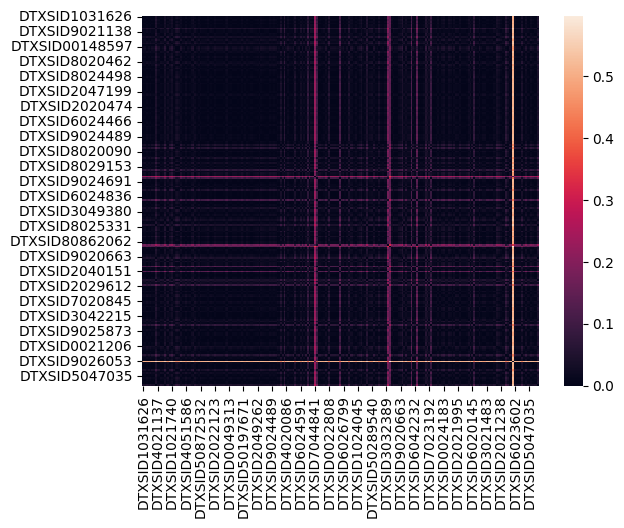

In [42]:
sns.heatmap(pd.DataFrame(squareform(pdist(embeddings_df, 'cosine')), index = embeddings.keys(), columns = embeddings.keys()))

In [48]:
rxn_domains = {k: group['DTXSID'].tolist() for k, group in llna.groupby('rxn') if len(group['DTXSID'].tolist()) >5}

In [56]:
def transform_matrix(df):
    a = df.where(np.triu(np.ones(df.shape)).astype('bool'))
    a = df.stack().reset_index()
    a = a.where(a.iloc[:,0] != a.iloc[:,1])
    a = a.dropna()
    a.columns = ['target', 'source', 'jaccard']
    a = a.sort_values(by = 'jaccard', ascending = False)
    a['bins'] = pd.cut(x = a['jaccard'], bins = [-0.000001,0.1,0.3, 0.5,0.7,1,1.5,2])
    return a, a['bins'].value_counts(dropna = False, normalize = True)

#rxn_domains
|Reaction domain|||Mol2Vec|ToxPrint|
|:---:|:---:|:---:|:---:|:---:|
|MA|Ethyl acrylate (DTXSID4020583)|Butyl acrylate (DTXSID6024676)|0.009583|0.66|
|MA|trans-2-decenal (DTXSID5047035)| trans-2-hexenal (DTXSID1041425)|0.014867|0.86|
|Acyl| Phthalic anhydride (DTXSID2021159)| Trimellitic anhydride (DTXSID7026235)|0.00674|0.7|

In [58]:
transform_matrix(D_cos)[1]

bins
(-1e-06, 0.1]    0.939913
(0.1, 0.3]       0.051037
(0.5, 0.7]       0.006155
(0.3, 0.5]       0.002894
(0.7, 1.0]       0.000000
(1.0, 1.5]       0.000000
(1.5, 2.0]       0.000000
Name: proportion, dtype: float64

In [52]:
D_cos.loc[['DTXSID4020583'], ['DTXSID6024676']]

,DTXSID6024676
DTXSID4020583,0.009583


In [53]:
D_cos.loc[['DTXSID5047035'], ['DTXSID1041425']]

,DTXSID1041425
DTXSID5047035,0.014867


In [54]:
D_cos.loc[['DTXSID2021159'], ['DTXSID7026235']]

,DTXSID7026235
DTXSID2021159,0.00674


In [59]:
def ecdf(data):
    '''
    Calculate the ecdf of a 1d-array
    Returns the x, y needed to plot the empirical ecdf
    '''
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1)/n
    return x, y

In [60]:
x1, y1 = ecdf(squareform(D_cos))

In [61]:
mydf = []
for k,v in rxn_domains.items():
    if k != 'non-reactive':
        x, y  = ecdf(squareform(D_cos.loc[v,v]))
        mydf.append([k, x,y])

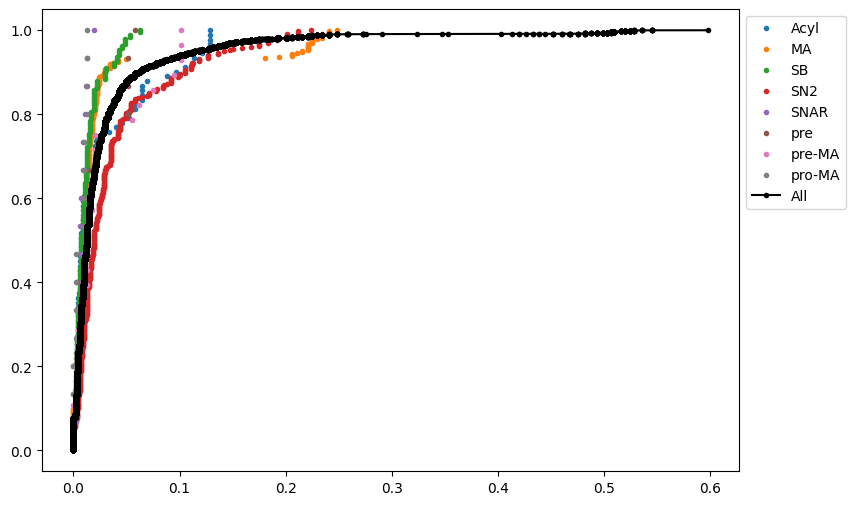

In [62]:
fig, ax = plt.subplots(figsize = (9,6))
for i in range(len(mydf)):
    ax.plot(mydf[i][1],mydf[i][2], marker = '.', linestyle = 'none', label = mydf[i][0])
    
ax.plot(x1, y1, linestyle = None, marker = '.', color = 'black', label = 'All')
ax.legend(bbox_to_anchor=(1, 1))

Took DSSTox QSAR ReadySmiles and tokenised based on Mol2Vec. 1/2 million substances formed the basis of the corpus from which a Word2Vec model was trained. Embeddings for the LLNA dataset were then generated and a pairwise cosine generated. Some differences seen in the entire LLNA data vs those substances tagged as in particular reaction domains. The cosine distances ECDFs were much steeper showing that the reaction domain substances were closely related to each other. There was some shift between SN2 substances vs SB and MA substances which could be expected. But applying it to find 'closest' neighbours did not retrieve substances based on the same rxn domain.

In [63]:
def nearest_neighbour(S, target, n = 10):
    t_m =S[target].values
    ids_chem = {i:x for i, x in enumerate(S.index)}
    temp_chem = np.argpartition(t_m, n)
    chem_nn = temp_chem[:n]
    nn_chem = [ids_chem[x] for x in chem_nn]
    mydict = {k:v for k,v in list(zip(nn_chem,t_m[chem_nn]))}
    df = pd.DataFrame(mydict.items(), columns = ['dtxsid', 'cosine']).sort_values(by = 'cosine', ascending = False)
    return df

In [64]:
nearest_neighbour(D_cos,'DTXSID6021903', 5)

,dtxsid,cosine
0,DTXSID6021583,0.010281
1,DTXSID6020515,0.000000
2,DTXSID0021206,0.000000
3,DTXSID1021740,0.000000
4,DTXSID6021903,0.000000


In [65]:
llna[llna['DTXSID'].isin(nearest_neighbour(D_cos,'DTXSID6021903', 5)['dtxsid'].tolist() )]

,DTXSID,CASRN,SMILES,reaction_chemistry_domain,LLNA,DPRA,KeratinoSens,hCLAT,rxn
12,DTXSID6021903,109-65-9,CCCCBr,SN2,0,1.0,0,1.0,SN2
16,DTXSID1021740,71-36-3,CCCCO,non-reactive,0,0.0,0,0.0,non-reactive
28,DTXSID6021583,431-03-8,CC(=O)C(C)=O,SB_or_MA,1,1.0,1,1.0,SB_or_MA
122,DTXSID6020515,68-12-2,CN(C)C=O,non-reactive,0,NaN,0,0.0,non-reactive
198,DTXSID0021206,57-55-6,CC(O)CO,non-reactive,0,0.0,0,0.0,non-reactive
